<a href="https://colab.research.google.com/github/a-fahim/jet-image-analysis/blob/main/pyJetAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
## pyJetAnalysis


In [1]:
!pip install numpythia
!pip install pyjet

# dir(numpythia)
# help(hepmc_write)

     |████████████████████████████████| 39.7MB 99kB/s 
     |████████████████████████████████| 1.2MB 4.0MB/s 


In [ ]:
from numpythia import Pythia , hepmc_write , hepmc_read
from numpythia import STATUS , HAS_END_VERTEX , ABS_PDG_ID
from pyjet import cluster, DTYPE_PTEPM

import numpythia, pyjet

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import LinearSegmentedColormap

import pandas as pd
import numpy as np
from numpy import pi

import os

os.popen('mkdir -p images')

phi_tuning = lambda p: -np.sign(p)*(2*pi - abs(p))*(abs(p) > pi)+p*(abs(p) <= pi)

params = {
    "Beams:eCM": 13000 , 
    "NewGaugeBoson:ffbar2Wprime":"on" , 
    "Wprime:coup2WZ":"1" , 
    "34:m0" : "800" ,
    "34:onMode" : "off" ,
    "34:onIfAny" : "23 24" ,
    "24:onMode" : "off" ,
    "24:onIfAny" : "1 2 3 4 5 6" ,
    "23:onMode" : "off" ,
    "23:onIfAny" : "12 14 16" ,
    }

# (-1, 0, 1), (r'anti-$k_t$', 'Cam/Aachen', '$k_t$')
jetAlg = -1 

pythia = Pythia(params=params, random_state=1)
for ev in hepmc_write('wpm.hepmc',pythia(events = 10)):
    ev.all()

selection = ((STATUS == 1) & ~HAS_END_VERTEX & (ABS_PDG_ID != 12) & (ABS_PDG_ID != 14) & (ABS_PDG_ID != 16))

eta_min, eta_max = -4., 4.
extent = eta_min, eta_max, -pi, pi
bins = 200

eta_edges = np.linspace(eta_min, eta_max, bins + 1)
phi_edges = np.linspace(-pi, pi, bins + 1)
eta = np.linspace(eta_min, eta_max, bins + 1)[:-1] + (eta_max - eta_min) / (2 * bins)
phi = np.linspace(-pi, pi, bins + 1)[:-1] + (pi / bins)
X, Y = np.meshgrid(eta, phi)

ghosts = np.zeros(eta.shape[0] * phi.shape[0], dtype=DTYPE_PTEPM)
ghosts['pT'] = 1e-8
ghosts['eta'] = X.ravel()
ghosts['phi'] = Y.ravel()

Jets = []

for i,ev in enumerate(hepmc_read('wpm.hepmc')):
    event = ev.all(selection)
    event = event[['pT','eta','phi','mass']]
    event = np.concatenate([event, ghosts], axis=0)
    sequence = cluster(event, R=1.0, p=jetAlg)
    jets = sequence.inclusive_jets(ptmin=50)
    for jet in jets:
        Jets.append(jet)

for j,jet in enumerate(Jets):

    J = jet.constituents_array()
    x,y,z=J['eta'],J['phi'],J['pT']

    ind = np.argmax(z)
    x0,y0 = x[ind],y[ind]
    x = x-x0
    y = y-y0

    y = phi_tuning(y)

    xmin,xmax,ymin,ymax,zmin,zmax = min(x),max(x),min(y),max(y),min(z),max(z)

    fig, ax = plt.subplots()
    ax.scatter(x, y, c='blue' , s=10*z, alpha=0.25)
    ax.set_xlabel(r'$\eta$', fontsize=15)
    ax.set_ylabel(r'$\phi$', fontsize=15)
    ax.set_title('Jet Constituent')

    fig.tight_layout()
    fig.savefig(f'images/jet_areas_{j}.png')


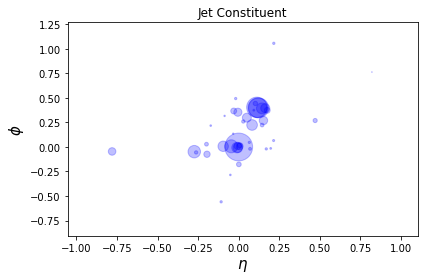

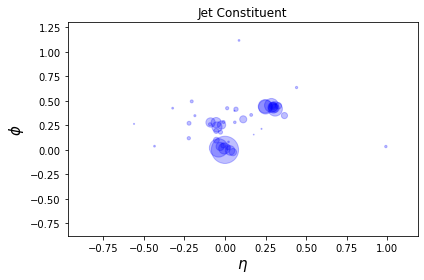

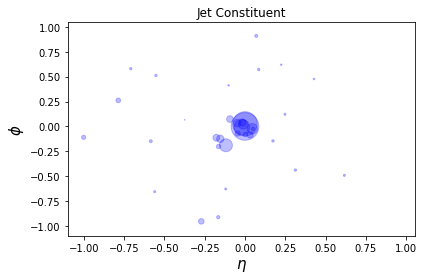

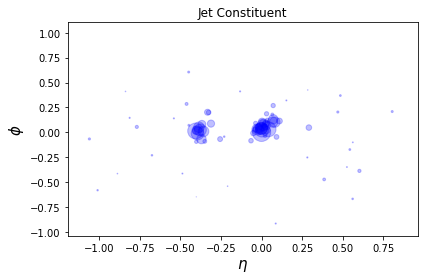

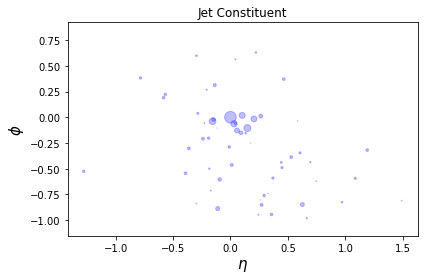

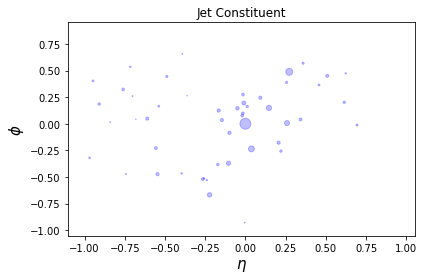

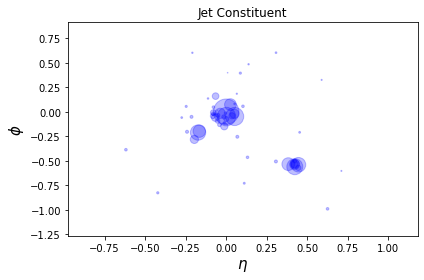

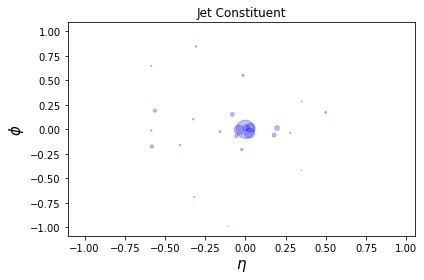

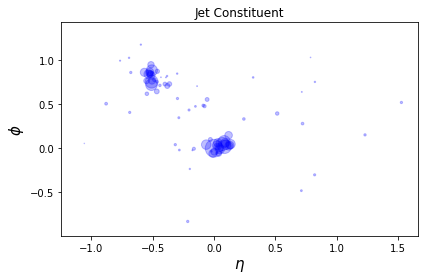

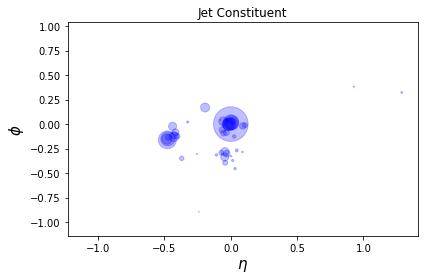

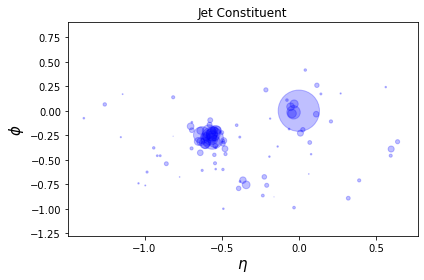

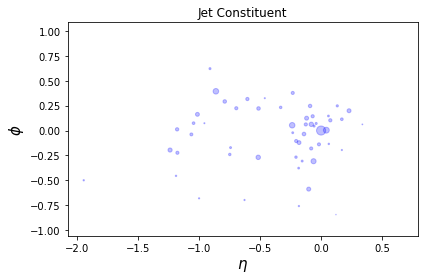

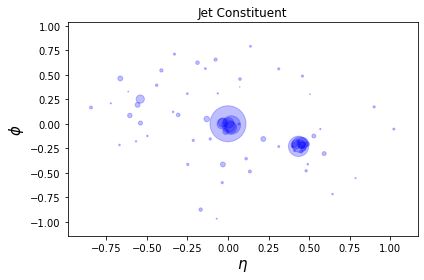

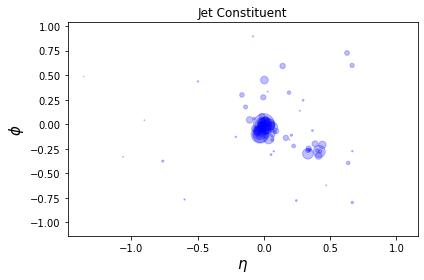

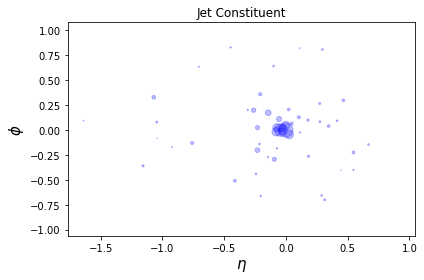